In [14]:
# ============================================================
#  NCD Risk Predictor - Improved Version to Prevent Overfitting
# ============================================================

import pandas as pd
import numpy as np
import warnings
import joblib
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.exceptions import ConvergenceWarning
from imblearn.over_sampling import SMOTE

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# STEP 1: Load & Preprocess NFHS-5
print("\n📥 Loading dataset...")
df = pd.read_csv("../1_data/NFHS_5_Factsheets_Data.csv")

# Rename required columns to avoid KeyError
rename_map = {
    "Women age 15 years and above who use any kind of tobacco (%)": "Tobacco_W",
    "Men age 15 years and above who use any kind of tobacco (%)": "Tobacco_M",
    "Women age 15 years and above who consume alcohol (%)": "Alcohol_W",
    "Men age 15 years and above who consume alcohol (%)": "Alcohol_M",
    "Women (age 15-49 years) who are overweight or obese (BMI ≥25.0 kg/m2)21 (%)": "Obese_W",
    "Women (age 15-49 years) whose Body Mass Index (BMI) is below normal (BMI <18.5 kg/m2)21 (%)": "Underweight_W",
    "Women (age 15-49)  with 10 or more years of schooling (%)": "School_W",
    "Households using clean fuel for cooking3 (%)": "CleanFuel_HH"
}
df = df.rename(columns=rename_map)

# Drop rows with missing data
all_cols = list(rename_map.values()) + ["Area"]
df = df.dropna(subset=all_cols)

# Label creation from tobacco + alcohol (do not include these as features)
for col in ["Tobacco_W", "Tobacco_M", "Alcohol_W", "Alcohol_M"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df["Risk_Score"] = df[["Tobacco_W", "Tobacco_M", "Alcohol_W", "Alcohol_M"]].sum(axis=1)
df["High_NCD_Risk"] = (df["Risk_Score"] > 80).astype(int)
df.dropna(subset=["Risk_Score", "High_NCD_Risk"], inplace=True)

# Handle missing values and cast features
for col in ["Obese_W", "Underweight_W", "School_W", "CleanFuel_HH"]:
    df[col] = pd.to_numeric(df[col].replace("*", np.nan), errors="coerce")

df.dropna(subset=["Obese_W", "Underweight_W", "School_W", "CleanFuel_HH"], inplace=True)

# Add binary rural feature
df["RuralFlag"] = (df["Area"].str.strip().str.lower() == "rural").astype(int)
feature_cols = ["Obese_W", "Underweight_W", "School_W", "CleanFuel_HH", "RuralFlag"]

X = df[feature_cols].astype(float).values
y = df["High_NCD_Risk"].values

# STEP 2: Split + Balance
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
X_train, y_train = SMOTE().fit_resample(X_train, y_train)

# STEP 3: Train Models
models = {
    "LogisticRegression": Pipeline([
        ("scale", StandardScaler()),
        ("clf", LogisticRegression(solver="liblinear", random_state=42))
    ]),
    "RandomForest": RandomForestClassifier(n_estimators=150, max_depth=5, random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=150, max_depth=3, learning_rate=0.05,
        subsample=0.7, colsample_bytree=0.7, reg_lambda=1.0,
        use_label_encoder=False, eval_metric="logloss", random_state=42
    )
}

# STEP 4: Evaluate with 5-Fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("\n🔍 5-Fold Cross-Validation Results:")
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, scoring="roc_auc", cv=cv, n_jobs=-1)
    print(f"{name:<18} AUC: {scores.mean():.3f} ± {scores.std():.3f}")

# STEP 5: Fit best model and evaluate on test set
best_model = models["RandomForest"]
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
print("\n🧪 Hold-Out Test Set Report:")
print(classification_report(y_test, y_pred, digits=3))

# STEP 6: Save to disk
joblib.dump(best_model, "../3_model/best_ncd_model.joblib")
print("\n✅ Model saved to 3_model/best_ncd_model.joblib")



📥 Loading dataset...

🔍 5-Fold Cross-Validation Results:
LogisticRegression AUC: 0.830 ± 0.077
RandomForest       AUC: 0.878 ± 0.061
XGBoost            AUC: 0.853 ± 0.074

🧪 Hold-Out Test Set Report:
              precision    recall  f1-score   support

           0      0.800     0.800     0.800        15
           1      0.571     0.571     0.571         7

    accuracy                          0.727        22
   macro avg      0.686     0.686     0.686        22
weighted avg      0.727     0.727     0.727        22


✅ Model saved to 3_model/best_ncd_model.joblib


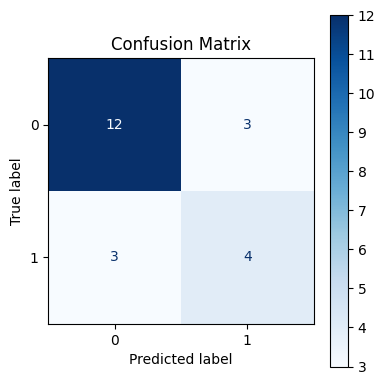

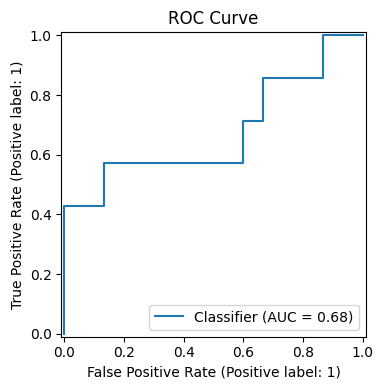

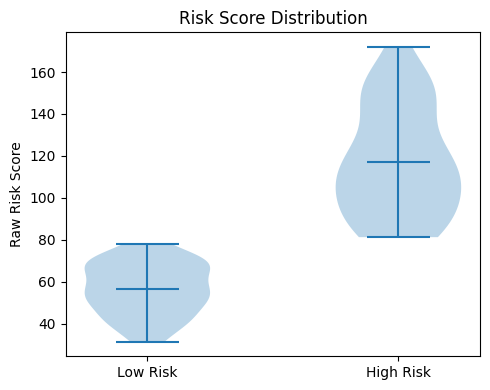

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

# ── 1. Confusion Matrix ───────────────────────
fig, ax = plt.subplots(figsize=(4, 4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap="Blues", values_format="d")
ax.set_title("Confusion Matrix")
plt.tight_layout()
plt.savefig("../3_model/confusion_matrix.png")
plt.show()

# ── 2. ROC Curve ───────────────────────────────
fig, ax = plt.subplots(figsize=(5, 4))
if hasattr(best_model, "predict_proba"):
    RocCurveDisplay.from_predictions(y_test, best_model.predict_proba(X_test)[:, 1], ax=ax)
else:
    RocCurveDisplay.from_predictions(y_test, best_model.decision_function(X_test), ax=ax)
ax.set_title("ROC Curve")
plt.tight_layout()
plt.savefig("../3_model/roc_curve.png")
plt.show()

# ── 3. Violin Plot: Raw Risk Scores ────────────
fig, ax = plt.subplots(figsize=(5, 4))
ax.violinplot([
    df[df["High_NCD_Risk"] == 0]["Risk_Score"],
    df[df["High_NCD_Risk"] == 1]["Risk_Score"]
], showmeans=True)
ax.set_xticks([1, 2])
ax.set_xticklabels(["Low Risk", "High Risk"])
ax.set_ylabel("Raw Risk Score")
ax.set_title("Risk Score Distribution")
plt.tight_layout()
plt.savefig("../3_model/risk_score_violin.png")
plt.show()
